In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output

In [2]:
print(tf.__version__)

2.12.0


In [3]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def __init__(self, metrics=[]):
        self.print_metrics = metrics
        print(self.print_metrics)

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x and x in self.print_metrics]

        f, axs = plt.subplots(len(metrics)//2 , 2, figsize=(20,10))
        
        clear_output(wait=True)
        axs = list(np.array(axs).flatten())

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric],
                        label=metric)
            
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([min(min(history.history['loss']), min(history.history['val_loss']))*0.8, max(max(history.history['loss']), max(history.history['val_loss']))*1.1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [monthly spend]')
    plt.legend()
    plt.grid(True)

In [4]:
dataset = pd.read_json('train_data.json')
dataset = dataset.drop(columns = ['time_as_client', 'profit', 'compliant'])

target = 'monthly_spend'

In [5]:
dataset

,residence_1_2_years,residence_3_years,residence_6_months_or_less,residence_7_12_months,bank_1_2_years,bank_3_years,bank_6_months_or_less,bank_7_12_months,monthly_income,monthly_rent,...,approved_income_ratio,score_tu,score_fico_money,score_lexisnexis,score_serasa,score_unit4,credit_line_requested,credit_line_approved,app_req_ratio,monthly_spend
0,0,0,1,0,0,1,0,0,100,950,...,11.000000,411,699,440,102,418,1500,1100,0.733333,9
1,0,1,0,0,0,1,0,0,10500,2400,...,2.371429,753,850,575,89,385,25500,24900,0.976471,2771
2,1,0,0,0,0,1,0,0,7700,100,...,1.051948,478,646,464,670,213,9000,8100,0.900000,866
3,0,1,0,0,0,0,1,0,3000,0,...,1.533333,780,850,690,305,398,5500,4600,0.836364,896
5,1,0,0,0,0,0,1,0,9900,900,...,3.010101,200,319,200,244,415,30500,29800,0.977049,590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9215,0,1,0,0,0,1,0,0,3300,3300,...,2.818182,781,544,684,11,508,10000,9300,0.930000,34
9216,0,1,0,0,0,0,0,1,14500,2450,...,0.186207,719,695,652,0,675,4500,2700,0.600000,1575
9217,0,1,0,0,1,0,0,0,3800,1400,...,0.315789,200,100,265,0,205,1500,1200,0.800000,540
9218,0,1,0,0,0,1,0,0,600,250,...,1.833333,727,519,592,38,580,1500,1100,0.733333,287


In [6]:
train_dataset = dataset.sample(frac=0.9, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [7]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

features = test_features.columns.drop(target)

train_labels = train_features.pop(target)
test_labels = test_features.pop(target)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))


In [8]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(32, activation='linear'),
        layers.Dense(64, activation='linear'),
        layers.Dense(8, activation='relu'),
        # layers.Dense(8, activation=lambda x: x**2),
        # layers.Dense(8, activation='relu'),
        # layers.Dropout(0.5),
        # layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])


    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                    0.5,
                    decay_steps = 1000,
                    decay_rate=10,
                    staircase=False)
    
    model.compile(loss='mean_absolute_error', metrics=[tf.keras.metrics.RootMeanSquaredError()],
                  optimizer=tf.keras.optimizers.Adam(lr_schedule))

    model.save_weights('initial_mspend_model.h5')
    
    return model



In [9]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 21)               43        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                704       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,388
Trainable params: 3,345
Non-trainable params: 43
_____________________________________________________

In [10]:
metrics_to_plot = ['loss', 'root_mean_squared_error']
callbacks_list = [PlotLearning(metrics_to_plot),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=25)]

dnn_model.load_weights('initial_mspend_model.h5')

# history = dnn_model.fit(
#     train_features,
#     train_labels,
#     validation_split=0.2,
#     verbose=1, 
#     epochs=200,
#     callbacks=callbacks_list)

['loss', 'root_mean_squared_error']


In [12]:
# plot_loss(history)

26/26 [==============================] - 0s 914us/step


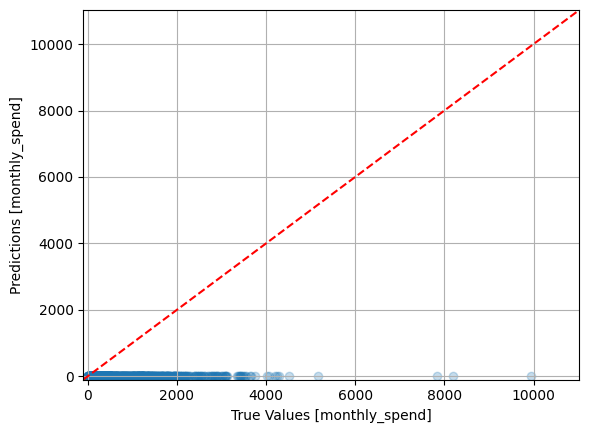

In [13]:
dnn_model.evaluate(test_features, test_labels, verbose=1)

test_predictions = dnn_model.predict(test_features).flatten()

plt.scatter(test_labels, test_predictions, alpha=0.25)
plt.xlabel('True Values [monthly_spend]')
plt.ylabel('Predictions [monthly_spend]')
lims = [min(min(test_labels), min(test_predictions))*0.9 - 100, max(max(test_labels), max(test_predictions))*1.1 + 100]
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.plot(lims, lims, 'r--')

count     816.000000
mean     -961.968801
std       972.642070
min     -9933.970787
25%     -1336.129085
50%      -673.139238
75%      -291.417543
max        -0.170962
Name: monthly_spend, dtype: float64


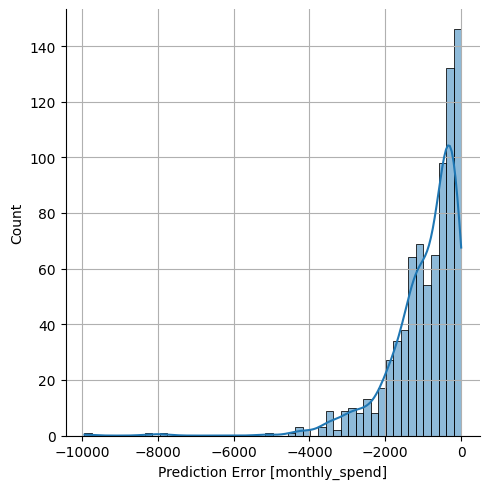

In [14]:
error = test_predictions - test_labels
print(error.describe())
sns.displot(error, bins=50, kde=True)
plt.grid()
plt.xlabel('Prediction Error [monthly_spend]')
_ = plt.ylabel('Count')

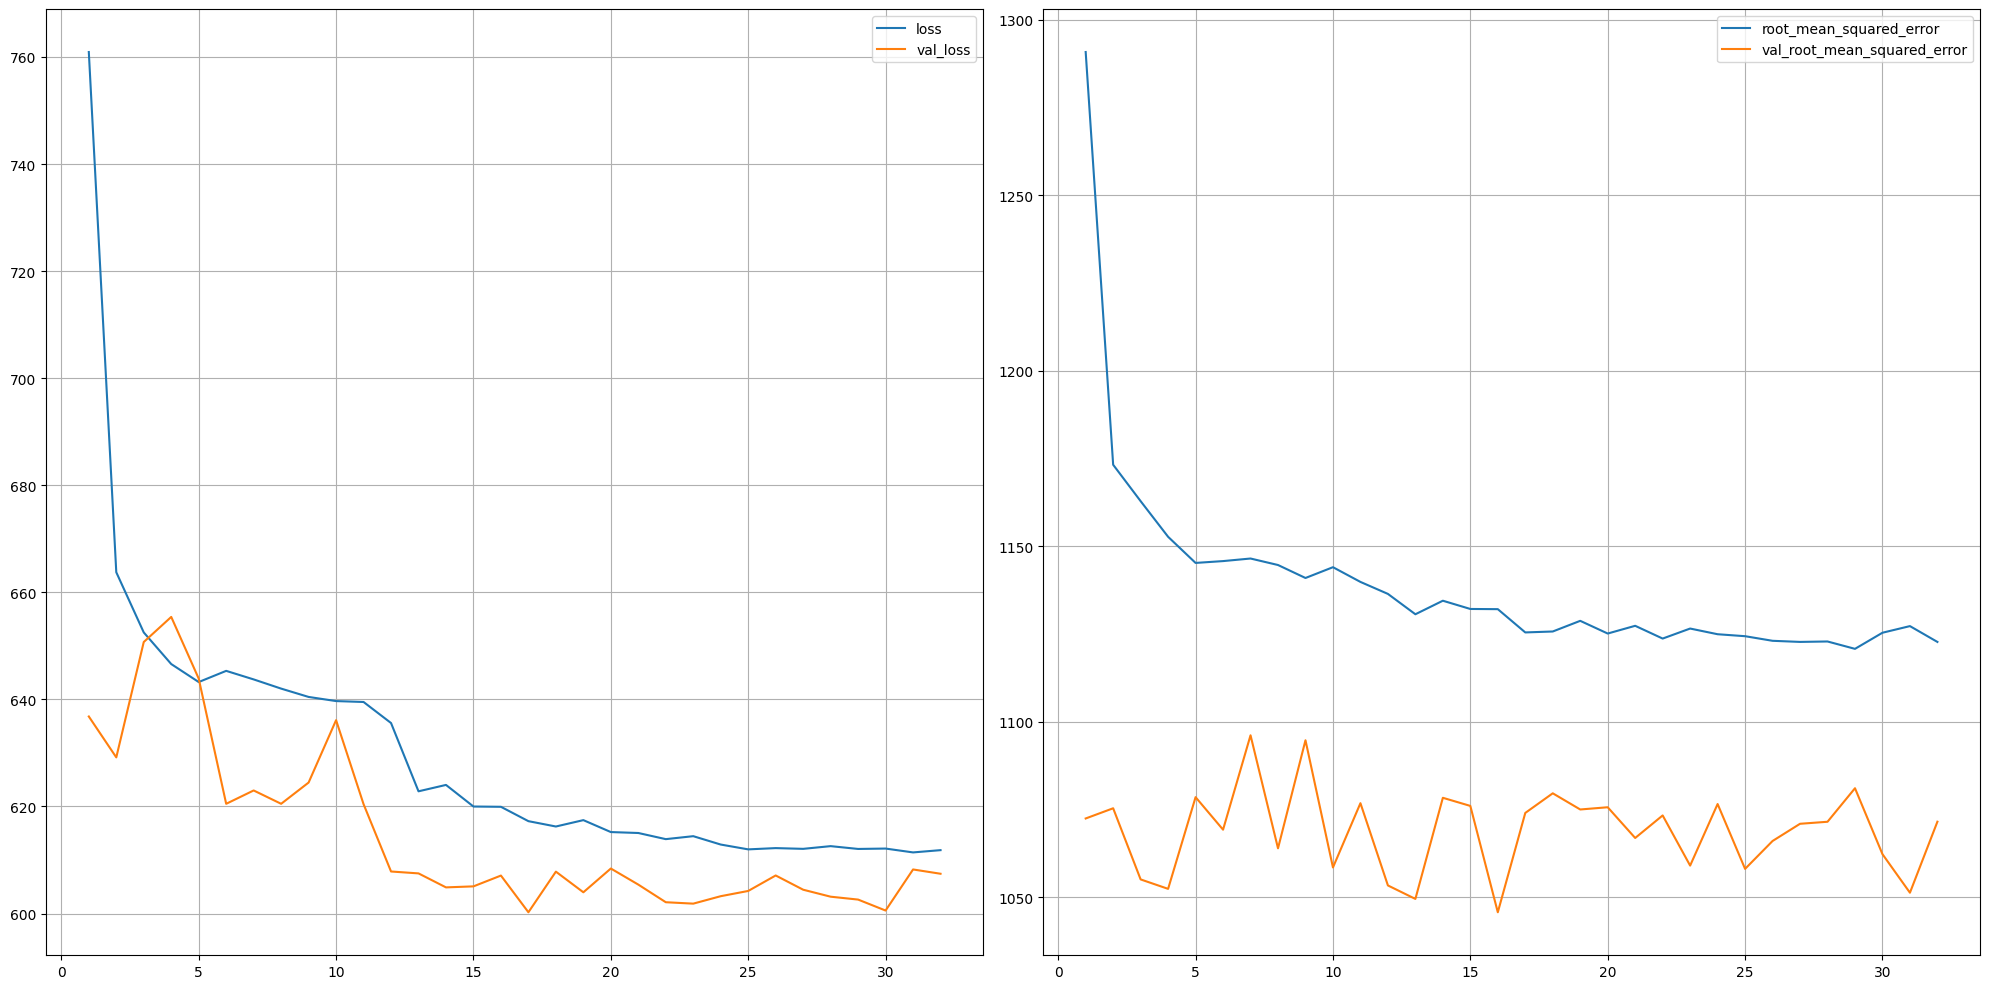

184/184 [==============================] - 1s 3ms/step - loss: 611.8459 - root_mean_squared_error: 1122.7439 - val_loss: 607.4371 - val_root_mean_squared_error: 1071.5421


In [15]:
metrics_to_plot = ['loss', 'root_mean_squared_error']
callbacks_list = [PlotLearning(metrics_to_plot),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=25)]

dnn_model.load_weights('initial_mspend_model.h5')

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, 
    epochs=200,
    callbacks=callbacks_list)

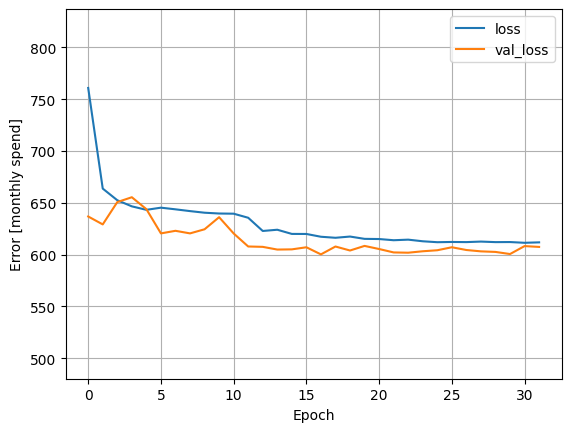

In [16]:
plot_loss(history)

26/26 [==============================] - 0s 832us/step


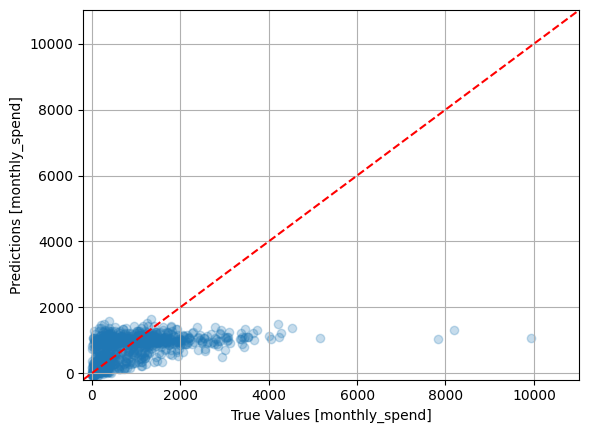

In [17]:
dnn_model.evaluate(test_features, test_labels, verbose=1)

test_predictions = dnn_model.predict(test_features).flatten()

plt.scatter(test_labels, test_predictions, alpha=0.25)
plt.xlabel('True Values [monthly_spend]')
plt.ylabel('Predictions [monthly_spend]')
lims = [min(min(test_labels), min(test_predictions))*0.9 - 100, max(max(test_labels), max(test_predictions))*1.1 + 100]
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.plot(lims, lims, 'r--')

count     816.000000
mean      180.364991
std       886.515214
min     -1254.552246
25%      -356.356567
50%        71.497437
75%       471.546581
max      8876.317139
Name: monthly_spend, dtype: float64


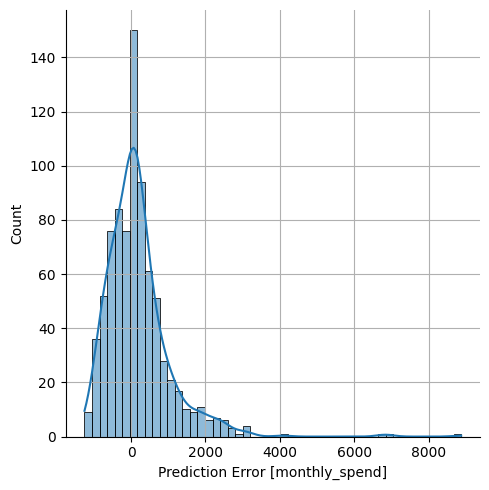

In [21]:
error = test_labels - test_predictions
print(error.describe())
sns.displot(error, bins=50, kde=True)
plt.grid()
plt.xlabel('Prediction Error [monthly_spend]')
_ = plt.ylabel('Count')

32/32 [==============================] - 0s 838us/step


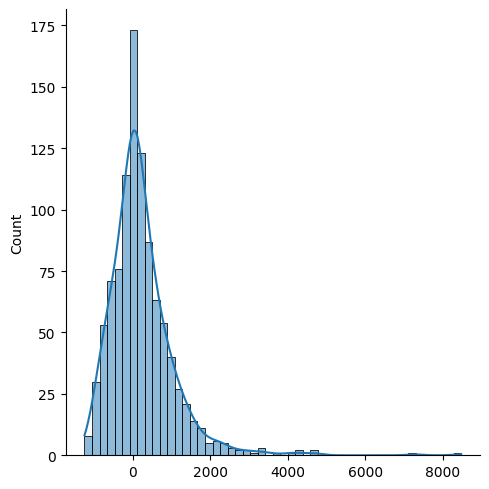

In [23]:
original_test_dataset = pd.read_json('test_data.json')
test_dataset_features = original_test_dataset[features]
test_dataset_target = original_test_dataset[[target]].copy()
predictions = dnn_model.predict(test_dataset_features).flatten()
original_test_dataset['predicted_monthly_spend'] = predictions
error = test_dataset_target[target] - original_test_dataset['predicted_monthly_spend']
sns.displot(error, bins=50, kde=True)

In [20]:
dnn_model.save('m_spend_regressor.dnn')

INFO:tensorflow:Assets written to: m_spend_regressor.dnn/assets


INFO:tensorflow:Assets written to: m_spend_regressor.dnn/assets


In [24]:
original_test_dataset.to_json('test_data_month_pred.json')